In [6]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.colors as mcolors
import pandas as pd
import matplotlib.gridspec as gridspec
import numpy as np
import seaborn as sns
import scipy
from scipy import stats

In [7]:
# Loading data from Google Sheets
import pandas as pd

url = "https://docs.google.com/spreadsheets/d/1ecopK6oyyb4d_7-QLrCr8YlgFrCetHU7-VQfnYej7JY/export?format=xlsx"
dataset = pd.ExcelFile(url, engine='openpyxl')

sheets = []
for sheet in dataset.sheet_names:
    df = dataset.parse(sheet)
    df["sheet"] = sheet #adding a column to track from which sheet is the data
    sheets.append(df)

df_airbnb = pd.concat(sheets, ignore_index=True)

In [8]:
# Check the shape of the combined DataFrame
df_airbnb.shape

(51707, 21)

In [9]:
# Exploratory Data Analysis (EDA)
# Create a column for country and weekday/weekend from group column
df_airbnb['city'] = df_airbnb['sheet'].str.split('_').str[0]
df_airbnb['weekday/weekend'] = df_airbnb['sheet'].str.split('_').str[1]


In [10]:
df_airbnb['city'].unique()

array(['amsterdam', 'athens', 'berlin', 'barcelona', 'budapest', 'lisbon',
       'london', 'paris', 'rome', 'vienna'], dtype=object)

In [11]:
# Create a column for country by mapping city names
country_map = {'amsterdam': 'netherlands', 
               'athens': 'greece',
               'berlin': 'germany',
               'barcelona': 'spain',
               'budapest': 'hungary',
               'lisbon': 'portugal',
               'london': 'uk',
               'paris': 'france',
               'rome': 'italy',
               'vienna': 'austria'}

df_airbnb['country'] = df_airbnb['city'].replace(country_map)

In [12]:
# Change the name of realSum to price
df_airbnb.rename(columns={'realSum': 'price'}, inplace=True)

In [13]:
# Instead of having two columns of room_shared and room_private, create one with the respective categories (was combined with room type)
df_airbnb['room_type'] = df_airbnb.apply(
    lambda row: 'shared room' if row['room_shared'] == True 
        else ('private room' if row['room_private'] == True 
              else 'entire home/apt'), axis=1)

df_airbnb = df_airbnb.drop(columns=['room_shared', 'room_private'])

In [14]:
# create a column where one can know if the host of the listing has only one, two to four, or more than four listings based on column multi and biz
df_airbnb['host_listing_count'] = df_airbnb.apply(
    lambda row: 'more than four' if row['biz'] == 1
    else ('one' if row['multi'] == 0
          else 'two to four'), axis=1)

df_airbnb = df_airbnb.drop(columns=['biz', 'multi'])

In [15]:
df_airbnb.shape

(51707, 21)

In [16]:
# Display the first entry
df_airbnb.head(1)

,Unnamed: 0,price,room_type,person_capacity,host_is_superhost,cleanliness_rating,guest_satisfaction_overall,bedrooms,dist,metro_dist,...,attr_index_norm,rest_index,rest_index_norm,lng,lat,sheet,city,weekday/weekend,country,host_listing_count
0,0,194.033698,private room,2,False,10,93,1,5.022964,2.53938,...,4.166708,98.253896,6.846473,4.90569,52.41772,amsterdam_weekdays,amsterdam,weekdays,netherlands,two to four


In [17]:
# Display the last entry
df_airbnb.tail(1)

,Unnamed: 0,price,room_type,person_capacity,host_is_superhost,cleanliness_rating,guest_satisfaction_overall,bedrooms,dist,metro_dist,...,attr_index_norm,rest_index,rest_index_norm,lng,lat,sheet,city,weekday/weekend,country,host_listing_count
51706,1798,133.230489,private room,4,True,10,93,1,1.263932,0.480903,...,10.774264,225.247293,5.44414,16.39066,48.20811,vienna_weekends,vienna,weekends,austria,two to four


In [18]:
# Display random sample of 7 entries
df_airbnb.sample(7)

,Unnamed: 0,price,room_type,person_capacity,host_is_superhost,cleanliness_rating,guest_satisfaction_overall,bedrooms,dist,metro_dist,...,attr_index_norm,rest_index,rest_index_norm,lng,lat,sheet,city,weekday/weekend,country,host_listing_count
25311,2849,317.269926,entire home/apt,2,False,9,92,1,5.880478,0.609027,...,13.637420,419.893304,7.518540,-0.14506,51.56003,london_weekdays,london,weekdays,uk,one
20456,900,498.827392,entire home/apt,5,False,10,93,2,0.274640,0.265458,...,15.170706,1178.373389,66.227701,-9.13700,38.71100,lisbon_weekends,lisbon,weekends,portugal,more than four
17372,673,409.005629,entire home/apt,6,False,8,89,2,0.116633,0.090418,...,14.792813,1237.466200,55.344106,-9.13964,38.71132,lisbon_weekdays,lisbon,weekdays,portugal,two to four
16697,1946,129.247544,entire home/apt,3,False,10,90,1,1.669951,0.272549,...,8.445427,321.138570,28.073275,19.07000,47.48800,budapest_weekends,budapest,weekends,hungary,more than four
6769,2036,148.337356,entire home/apt,3,False,10,96,1,1.664188,0.237974,...,6.523108,232.790913,3.476485,23.72424,37.96345,athens_weekends,athens,weekends,greece,one
47932,4297,211.348280,entire home/apt,4,False,10,95,2,1.339098,0.866170,...,6.932671,822.535904,17.921062,12.51586,41.89440,rome_weekends,rome,weekends,italy,two to four
654,654,371.194901,private room,2,False,9,78,0,0.855121,0.684349,...,24.747757,675.131605,47.044142,4.88447,52.36765,amsterdam_weekdays,amsterdam,weekdays,netherlands,more than four


In [19]:
# Check data types
df_airbnb.dtypes

Unnamed: 0                      int64
price                         float64
room_type                      object
person_capacity                 int64
host_is_superhost                bool
cleanliness_rating              int64
guest_satisfaction_overall      int64
bedrooms                        int64
dist                          float64
metro_dist                    float64
attr_index                    float64
attr_index_norm               float64
rest_index                    float64
rest_index_norm               float64
lng                           float64
lat                           float64
sheet                          object
city                           object
weekday/weekend                object
country                        object
host_listing_count             object
dtype: object

In [20]:
# basic summary statistics for numeric data
df_airbnb.describe()

,Unnamed: 0,price,person_capacity,cleanliness_rating,guest_satisfaction_overall,bedrooms,dist,metro_dist,attr_index,attr_index_norm,rest_index,rest_index_norm,lng,lat
count,51707.000000,51707.000000,51707.000000,51707.000000,51707.000000,51707.00000,51707.000000,51707.000000,51707.000000,51707.000000,51707.000000,51707.000000,51707.000000,51707.000000
mean,1620.502388,279.879591,3.161661,9.390624,92.628232,1.15876,3.191285,0.681540,294.204105,13.423792,626.856696,22.786177,7.426068,45.671128
std,1217.380366,327.948386,1.298545,0.954868,8.945531,0.62741,2.393803,0.858023,224.754123,9.807985,497.920226,17.804096,9.799725,5.249263
min,0.000000,34.779339,2.000000,2.000000,20.000000,0.00000,0.015045,0.002301,15.152201,0.926301,19.576924,0.592757,-9.226340,37.953000
25%,646.000000,148.752174,2.000000,9.000000,90.000000,1.00000,1.453142,0.248480,136.797385,6.380926,250.854114,8.751480,-0.072500,41.399510
50%,1334.000000,211.343089,3.000000,10.000000,95.000000,1.00000,2.613538,0.413269,234.331748,11.468305,522.052783,17.542238,4.873000,47.506690
75%,2382.000000,319.694287,4.000000,10.000000,99.000000,1.00000,4.263077,0.737840,385.756381,17.415082,832.628988,32.964603,13.518825,51.471885
max,5378.000000,18545.450285,6.000000,10.000000,100.000000,10.00000,25.284557,14.273577,4513.563486,100.000000,6696.156772,100.000000,23.786020,52.641410


In [21]:
# basic summary statistics for categorical data
df_airbnb.describe(include="object")

,room_type,sheet,city,weekday/weekend,country,host_listing_count
count,51707,51707,51707,51707,51707,51707
unique,3,20,10,2,10,3
top,entire home/apt,london_weekends,london,weekends,uk,one
freq,32648,5379,9993,26207,9993,18534


In [22]:
pd.set_option('display.max_columns', None)


/Users/Anna/miniforge3/envs/asda2025/lib/python3.11/site-packages/cartopy/io/__init__.py:242: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_physical/ne_50m_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/Users/Anna/miniforge3/envs/asda2025/lib/python3.11/site-packages/cartopy/io/__init__.py:242: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_physical/ne_50m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/Users/Anna/miniforge3/envs/asda2025/lib/python3.11/site-packages/cartopy/io/__init__.py:242: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_cultural/ne_50m_admin_0_boundary_lines_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/Users/Anna/miniforge3/envs/asda2025/lib/python3.11/site-packages/shapely/creation.py:730: RuntimeWarning: invalid value encountered in create_collection
  return lib.create_collection(geometries, np.intc(typ), out=out, **kwargs)
/

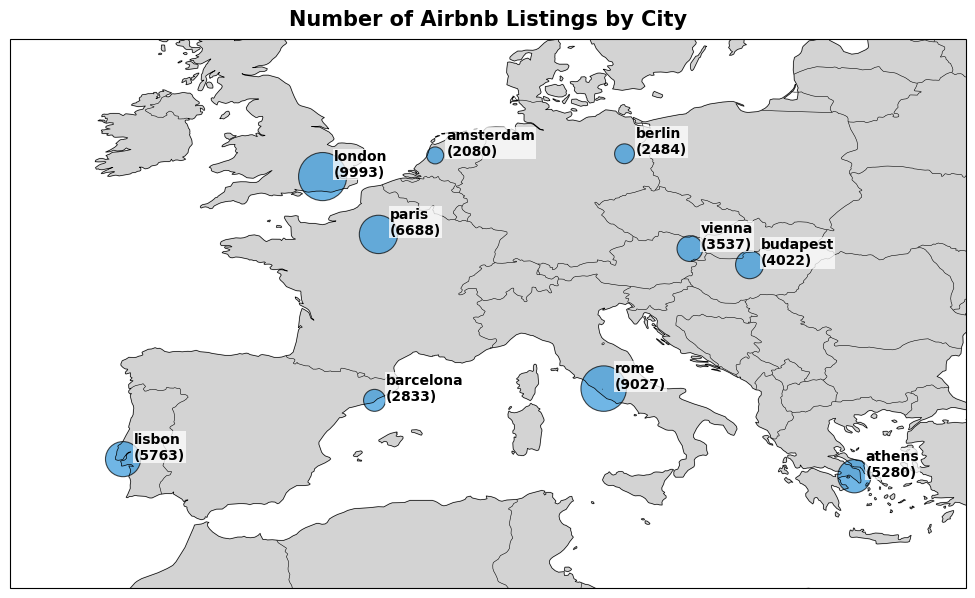

In [23]:
# --- Listing count per city ---
city_counts = (
    df_airbnb.groupby("city", as_index=False)
    .size()
    .rename(columns={"size": "listing_count"})
)

# --- Merge with city coordinates ---
unique_cities = df_airbnb.drop_duplicates(subset=["city"])[["city", "lat", "lng"]]
city_data = pd.merge(unique_cities, city_counts, on="city")

# --- Setup figure ---
fig = plt.figure(figsize=(10, 6))
ax = plt.subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.set_title("Number of Airbnb Listings by City", fontsize=15, weight="bold", pad=10)

# Base map
ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
ax.add_feature(cfeature.BORDERS, linewidth=0.4)
ax.add_feature(cfeature.LAND, color="lightgrey")

# Map bounds
x_min, x_max = df_airbnb["lng"].min() - 5, df_airbnb["lng"].max() + 5
y_min, y_max = df_airbnb["lat"].min() - 5, df_airbnb["lat"].max() + 5
ax.set_extent([x_min, x_max, y_min, y_max], crs=ccrs.PlateCarree())

# Normalize bubble sizes
min_size, max_size = 150, 1200
sizes = np.interp(city_data["listing_count"],
                  (city_data["listing_count"].min(), city_data["listing_count"].max()),
                  (min_size, max_size))

# Plot bubbles
ax.scatter(city_data["lng"], city_data["lat"],
           s=sizes, color="#3498DB", alpha=0.7,
           edgecolor="black", linewidth=0.8,
           transform=ccrs.PlateCarree())

# Labels
for _, row in city_data.iterrows():
    ax.text(row["lng"] + 0.5, row["lat"],
            f"{row['city']}\n({row['listing_count']})",
            fontsize=10, weight="bold",
            transform=ccrs.PlateCarree(),
            bbox=dict(facecolor="white", alpha=0.75, edgecolor="none", pad=0.6))

plt.tight_layout()
plt.show()


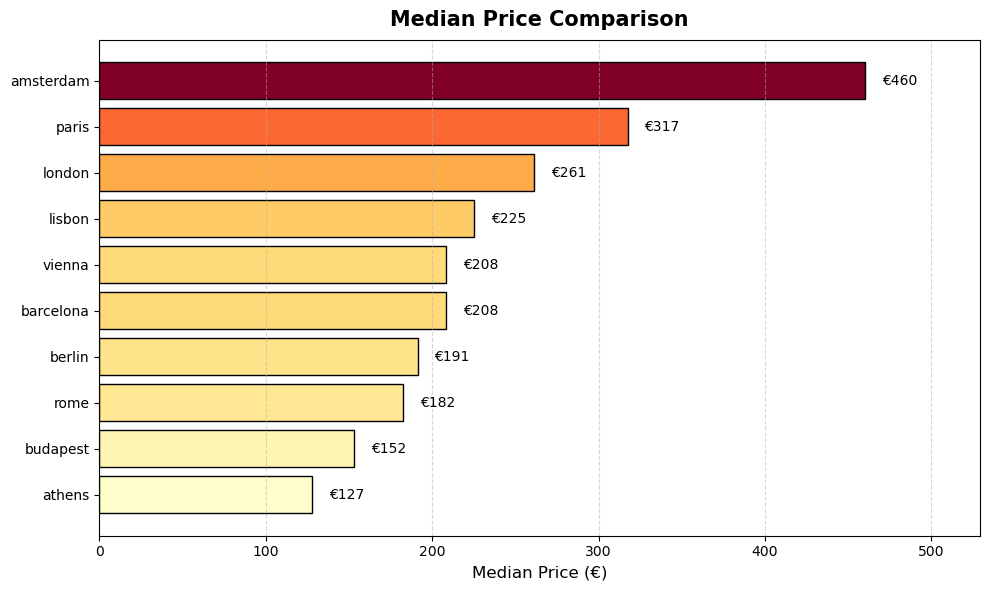

In [24]:
# --- Median price per city ---
median_price = (
    df_airbnb.groupby("city", as_index=False)["price"]
    .median()
    .rename(columns={"price": "median_price"})
)

# Sort by price
city_data_sorted = median_price.sort_values("median_price", ascending=True)

# Colormap
cmap = plt.colormaps["YlOrRd"]
norm = mcolors.Normalize(vmin=city_data_sorted["median_price"].min(),
                         vmax=city_data_sorted["median_price"].max())
bar_colors = [cmap(norm(v)) for v in city_data_sorted["median_price"]]

# --- Plot ---
plt.figure(figsize=(10, 6))
plt.barh(city_data_sorted["city"], city_data_sorted["median_price"],
         color=bar_colors, edgecolor="black")

# Labels & Title
plt.title("Median Price Comparison", fontsize=15, weight="bold", pad=10)
plt.xlabel("Median Price (€)", fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.xlim(0, city_data_sorted["median_price"].max() * 1.15)

# Value labels
for i, v in enumerate(city_data_sorted["median_price"]):
    plt.text(v + 10, i, f"€{int(v)}", va="center", fontsize=10)

plt.tight_layout()
plt.show()


/Users/Anna/miniforge3/envs/asda2025/lib/python3.11/site-packages/shapely/creation.py:730: RuntimeWarning: invalid value encountered in create_collection
  return lib.create_collection(geometries, np.intc(typ), out=out, **kwargs)
/Users/Anna/miniforge3/envs/asda2025/lib/python3.11/site-packages/shapely/creation.py:730: RuntimeWarning: invalid value encountered in create_collection
  return lib.create_collection(geometries, np.intc(typ), out=out, **kwargs)
/Users/Anna/miniforge3/envs/asda2025/lib/python3.11/site-packages/shapely/creation.py:730: RuntimeWarning: invalid value encountered in create_collection
  return lib.create_collection(geometries, np.intc(typ), out=out, **kwargs)
/Users/Anna/miniforge3/envs/asda2025/lib/python3.11/site-packages/shapely/creation.py:730: RuntimeWarning: invalid value encountered in create_collection
  return lib.create_collection(geometries, np.intc(typ), out=out, **kwargs)
/Users/Anna/miniforge3/envs/asda2025/lib/python3.11/site-packages/shapely/creati

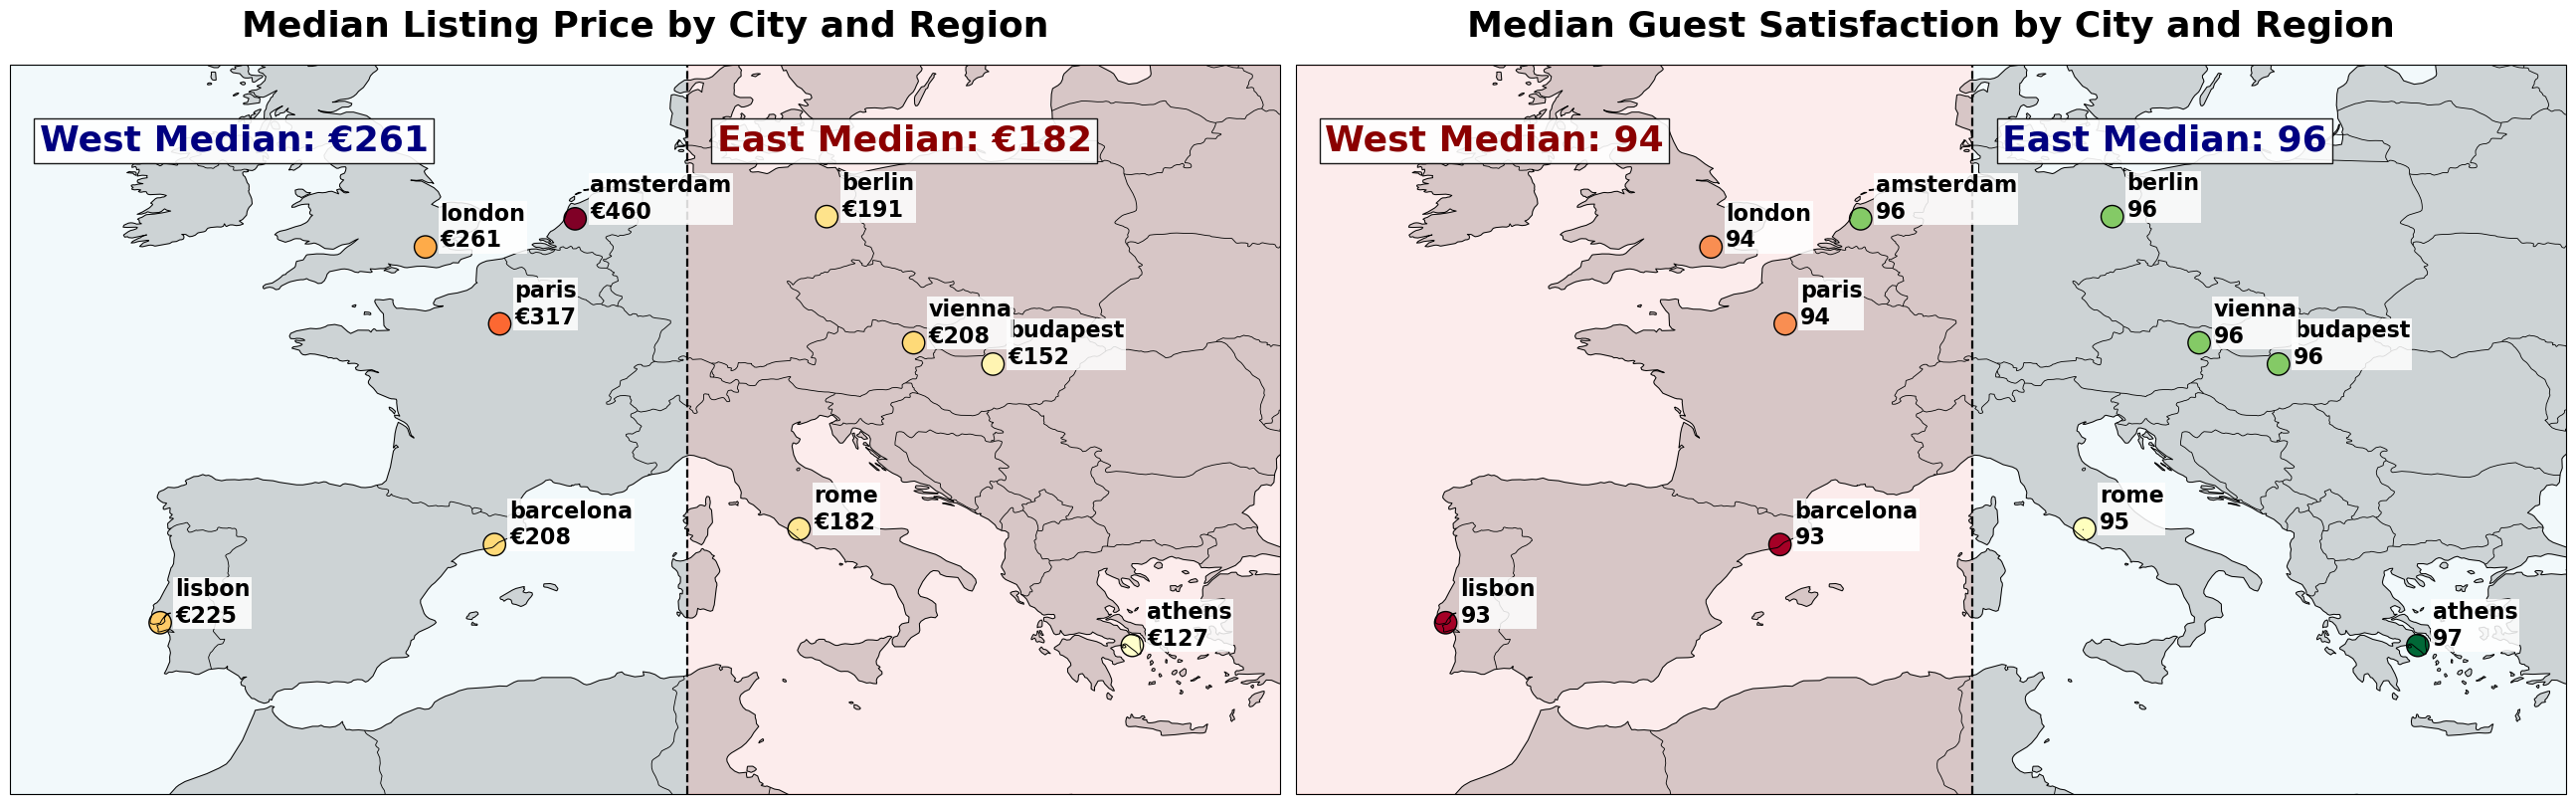

In [25]:

# --- Median price per city ---
median_price = (
    df_airbnb.groupby("city", as_index=False)["price"]
    .median()
    .rename(columns={"price": "median_price"})
)

# --- Median satisfaction per city ---
median_satisfaction = (
    df_airbnb.groupby("city", as_index=False)["guest_satisfaction_overall"]
    .median()
    .rename(columns={"guest_satisfaction_overall": "median_satisfaction"})
)

# --- Merge with coordinates ---
unique_cities = df_airbnb.drop_duplicates(subset=["city"])[["city", "lat", "lng"]]
city_data = pd.merge(unique_cities, median_price, on="city")
city_data = pd.merge(city_data, median_satisfaction, on="city")

# --- Dynamic midpoint longitude ---
divider_longitude = city_data["lng"].median()
city_data["region"] = np.where(city_data["lng"] <= divider_longitude, "West", "East")

# --- Compute regional medians ---
region_medians_price = city_data.groupby("region")["median_price"].median().to_dict()
region_medians_satisfaction = city_data.groupby("region")["median_satisfaction"].median().to_dict()

# --- Colormaps ---
cmap_price = plt.colormaps["YlOrRd"]
norm_price = mcolors.Normalize(vmin=city_data["median_price"].min(),
                               vmax=city_data["median_price"].max())

cmap_sat = plt.colormaps["RdYlGn"]
norm_sat = mcolors.Normalize(vmin=city_data["median_satisfaction"].min(),
                             vmax=city_data["median_satisfaction"].max())

# --- Bigger figure for readability ---
fig, axes = plt.subplots(1, 2, figsize=(26, 11), subplot_kw={'projection': ccrs.PlateCarree()})

# Map extent
x_min, x_max = df_airbnb["lng"].min() - 5, df_airbnb["lng"].max() + 5
y_min, y_max = df_airbnb["lat"].min() - 5, df_airbnb["lat"].max() + 5

# Font sizes for consistency
CITY_FONT = 16
MEDIAN_FONT = 26
TITLE_FONT = 26

# ---------------------------------------------------------------------
# 🧭 LEFT MAP — Median Price
# ---------------------------------------------------------------------
ax1 = axes[0]
ax1.add_feature(cfeature.COASTLINE, linewidth=0.7)
ax1.add_feature(cfeature.BORDERS, linewidth=0.6)
ax1.add_feature(cfeature.LAND, color="lightgrey")
ax1.set_title("Median Listing Price by City and Region", fontsize=TITLE_FONT, weight="bold", pad=20)

# Region shading
ax1.fill_betweenx([y_min, y_max], x_min, divider_longitude,
                  color="lightblue", alpha=0.15, transform=ccrs.PlateCarree())
ax1.fill_betweenx([y_min, y_max], divider_longitude, x_max,
                  color="lightcoral", alpha=0.15, transform=ccrs.PlateCarree())

# Scatter
scatter1 = ax1.scatter(city_data["lng"], city_data["lat"],
                       c=city_data["median_price"],
                       cmap=cmap_price, norm=norm_price,
                       s=260, edgecolor="black",
                       transform=ccrs.PlateCarree())

# City labels
for _, row in city_data.iterrows():
    ax1.text(row["lng"] + 0.5, row["lat"],
             f"{row['city']}\n€{int(row['median_price'])}",
             fontsize=CITY_FONT, weight="bold",
             transform=ccrs.PlateCarree(),
             bbox=dict(facecolor="white", alpha=0.85, edgecolor="none", pad=1.2))

# Regional medians
ax1.text(x_min + 1, y_max - 2, f"West Median: €{int(region_medians_price['West'])}",
         fontsize=MEDIAN_FONT, color="navy", weight="bold",
         transform=ccrs.PlateCarree(),
         ha="left", va="top",
         bbox=dict(facecolor="white", alpha=0.9, edgecolor="black"))

ax1.text(divider_longitude + 1, y_max - 2, f"East Median: €{int(region_medians_price['East'])}",
         fontsize=MEDIAN_FONT, color="darkred", weight="bold",
         transform=ccrs.PlateCarree(),
         ha="left", va="top",
         bbox=dict(facecolor="white", alpha=0.9, edgecolor="black"))

# Divider line
ax1.plot([divider_longitude, divider_longitude], [y_min, y_max],
         color="black", linestyle="--", linewidth=1.6, transform=ccrs.PlateCarree())
ax1.set_extent([x_min, x_max, y_min, y_max], crs=ccrs.PlateCarree())

# ---------------------------------------------------------------------
# 🌟 RIGHT MAP — Median Guest Satisfaction (flipped hues)
# ---------------------------------------------------------------------
ax2 = axes[1]
ax2.add_feature(cfeature.COASTLINE, linewidth=0.7)
ax2.add_feature(cfeature.BORDERS, linewidth=0.6)
ax2.add_feature(cfeature.LAND, color="lightgrey")
ax2.set_title("Median Guest Satisfaction by City and Region", fontsize=TITLE_FONT, weight="bold", pad=20)

# Region shading (flipped colors)
ax2.fill_betweenx([y_min, y_max], x_min, divider_longitude,
                  color="lightcoral", alpha=0.15, transform=ccrs.PlateCarree())
ax2.fill_betweenx([y_min, y_max], divider_longitude, x_max,
                  color="lightblue", alpha=0.15, transform=ccrs.PlateCarree())

# Scatter
scatter2 = ax2.scatter(city_data["lng"], city_data["lat"],
                       c=city_data["median_satisfaction"],
                       cmap=cmap_sat, norm=norm_sat,
                       s=260, edgecolor="black",
                       transform=ccrs.PlateCarree())

# City labels
for _, row in city_data.iterrows():
    ax2.text(row["lng"] + 0.5, row["lat"],
             f"{row['city']}\n{int(row['median_satisfaction'])}",
             fontsize=CITY_FONT, weight="bold",
             transform=ccrs.PlateCarree(),
             bbox=dict(facecolor="white", alpha=0.85, edgecolor="none", pad=1.2))

# Regional medians
ax2.text(x_min + 1, y_max - 2, f"West Median: {int(region_medians_satisfaction['West'])}",
         fontsize=MEDIAN_FONT, color="darkred", weight="bold",
         transform=ccrs.PlateCarree(),
         ha="left", va="top",
         bbox=dict(facecolor="white", alpha=0.9, edgecolor="black"))

ax2.text(divider_longitude + 1, y_max - 2, f"East Median: {int(region_medians_satisfaction['East'])}",
         fontsize=MEDIAN_FONT, color="navy", weight="bold",
         transform=ccrs.PlateCarree(),
         ha="left", va="top",
         bbox=dict(facecolor="white", alpha=0.9, edgecolor="black"))

# Divider line
ax2.plot([divider_longitude, divider_longitude], [y_min, y_max],
         color="black", linestyle="--", linewidth=1.6, transform=ccrs.PlateCarree())
ax2.set_extent([x_min, x_max, y_min, y_max], crs=ccrs.PlateCarree())

# ---------------------------------------------------------------------
# 🧹 Final cleanup
# ---------------------------------------------------------------------
plt.tight_layout()
plt.show()


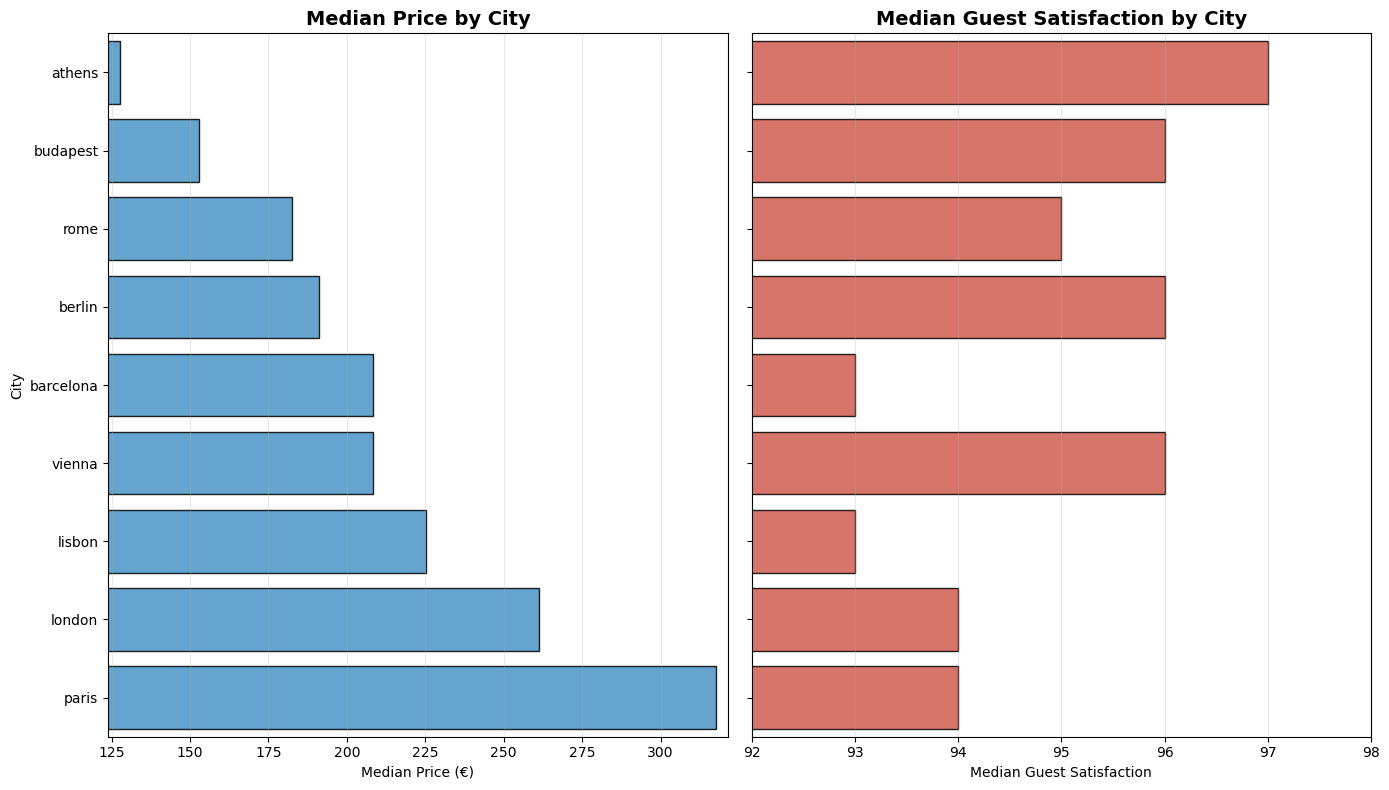

In [26]:
# Step 1️⃣: Compute median stats per city and remove Amsterdam
median_city_stats = (
    df_airbnb.groupby("city")[["price", "guest_satisfaction_overall"]]
    .median()
    .reset_index()
)

# Remove Amsterdam (case-insensitive)
median_city_stats = median_city_stats[median_city_stats["city"].str.lower() != "amsterdam"]

# Step 2️⃣: Sort by Median Price (descending)
median_city_stats = median_city_stats.sort_values("price", ascending=True)

# Step 3️⃣: Create two subplots — one for satisfaction, one for price
fig, axes = plt.subplots(1, 2, figsize=(14, 8), sharey=True)

# --- 🔵 Plot 1: Median Price ---
sns.barplot(
    data=median_city_stats,
    x="price",
    y="city",
    color="#3498DB",
    alpha=0.85,
    edgecolor="black",
    ax=axes[0]
)

# Magnify price axis
min_price = median_city_stats["price"].min()
max_price = median_city_stats["price"].max()
price_range = max_price - min_price
axes[0].set_xlim(min_price - price_range * 0.02, max_price + price_range * 0.02)

axes[0].set_title("Median Price by City", fontsize=14, weight="bold")
axes[0].set_xlabel("Median Price (€)")
axes[0].set_ylabel("City")
axes[0].grid(axis='x', alpha=0.3)

# --- 🔴 Plot 2: Median Guest Satisfaction ---
sns.barplot(
    data=median_city_stats,
    x="guest_satisfaction_overall",
    y="city",
    color="#E74C3C",
    alpha=0.85,
    edgecolor="black",
    ax=axes[1]
)

# Magnify satisfaction axis
min_sat = median_city_stats["guest_satisfaction_overall"].min()
max_sat = median_city_stats["guest_satisfaction_overall"].max()
axes[1].set_xlim(min_sat - 1, max_sat + 1)

axes[1].set_title("Median Guest Satisfaction by City", fontsize=14, weight="bold")
axes[1].set_xlabel("Median Guest Satisfaction")
axes[1].set_ylabel("")
axes[1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()


/var/folders/lc/rwbnk4114w78tcfk73z_364m0000gn/T/ipykernel_1353/3317072726.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/var/folders/lc/rwbnk4114w78tcfk73z_364m0000gn/T/ipykernel_1353/3317072726.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(["Non-Superhost", "Superhost"])
/var/folders/lc/rwbnk4114w78tcfk73z_364m0000gn/T/ipykernel_1353/3317072726.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


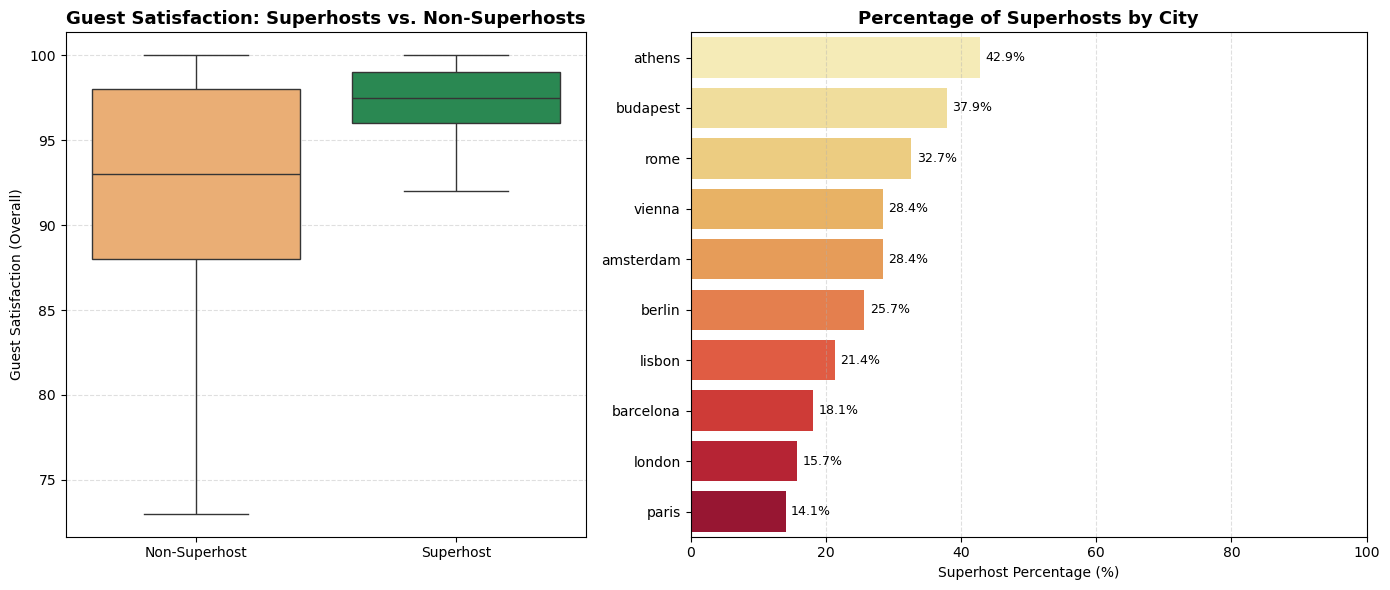

In [27]:

# ---------- 1️⃣ Percentage of superhosts by city ----------
superhost_counts = df_airbnb.groupby(["host_is_superhost", "city"]).size().unstack(fill_value=0)
superhost_pct = (superhost_counts.loc[True] / superhost_counts.sum()) * 100
superhost_pct = superhost_pct.sort_values(ascending=False)

# ---------- 2️⃣ Create figure with two subplots ----------
fig, axes = plt.subplots(1, 2, figsize=(14, 6), gridspec_kw={'width_ratios': [1, 1.3]})

# ---------- 3️⃣ LEFT: Guest Satisfaction by Superhost status ----------
sns.boxplot(
    data=df_airbnb,
    x="host_is_superhost",
    y="guest_satisfaction_overall",
    palette=["#fdae61", "#1a9850"],
    showfliers=False,
    ax=axes[0]
)

axes[0].set_xticklabels(["Non-Superhost", "Superhost"])
axes[0].set_title("Guest Satisfaction: Superhosts vs. Non-Superhosts", fontsize=13, weight="bold")
axes[0].set_xlabel("")
axes[0].set_ylabel("Guest Satisfaction (Overall)")
axes[0].grid(axis="y", linestyle="--", alpha=0.4)

# ---------- 4️⃣ RIGHT: Percentage of Superhosts per city ----------
sns.barplot(
    x=superhost_pct.values,
    y=superhost_pct.index,
    palette="YlOrRd",
    ax=axes[1]
)

# Add percentage labels to bars
for i, val in enumerate(superhost_pct.values):
    axes[1].text(val + 0.8, i, f"{val:.1f}%", va="center", fontsize=9)

axes[1].set_title("Percentage of Superhosts by City", fontsize=13, weight="bold")
axes[1].set_xlabel("Superhost Percentage (%)")
axes[1].set_ylabel("")
axes[1].set_xlim(0, 100)
axes[1].grid(axis="x", linestyle="--", alpha=0.4)

# ---------- 5️⃣ Layout ----------
plt.tight_layout()
plt.show()


/var/folders/lc/rwbnk4114w78tcfk73z_364m0000gn/T/ipykernel_1353/4164557814.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_temp.groupby("price_quartile")["guest_satisfaction_overall"]
/var/folders/lc/rwbnk4114w78tcfk73z_364m0000gn/T/ipykernel_1353/4164557814.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/var/folders/lc/rwbnk4114w78tcfk73z_364m0000gn/T/ipykernel_1353/4164557814.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


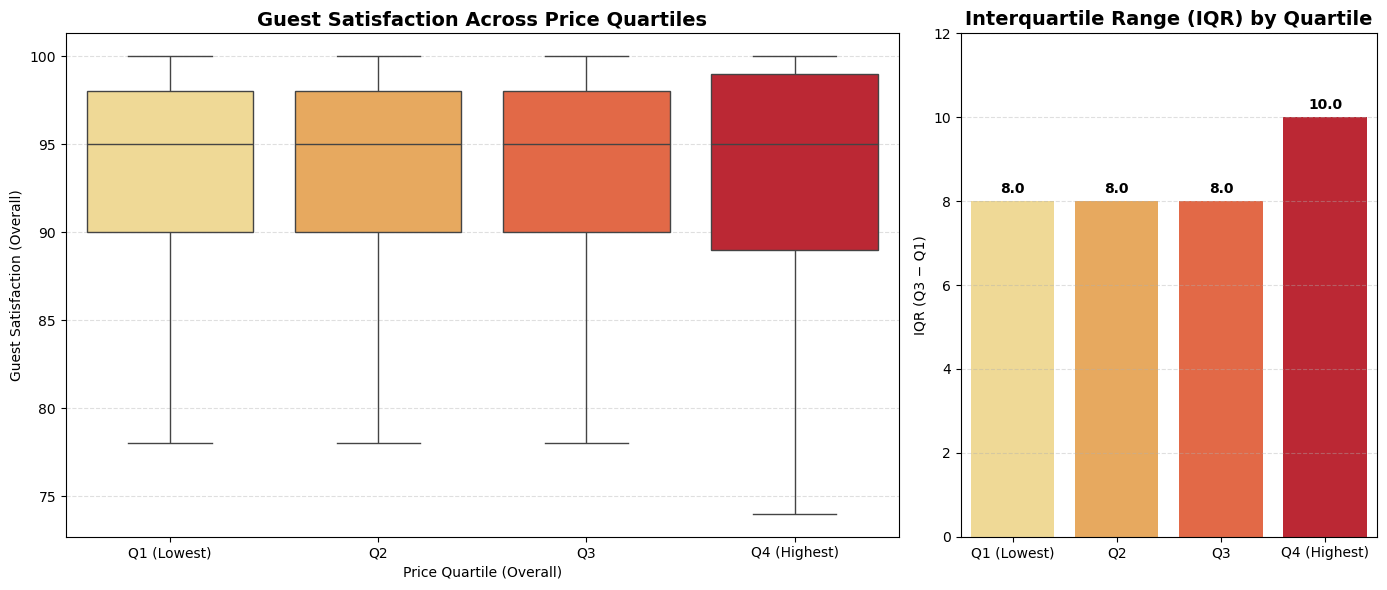

In [28]:


# ---------- 1️⃣ Create price quartiles ----------
df_temp = df_airbnb.copy()
df_temp["price_quartile"] = pd.qcut(
    df_temp["price"],
    q=4,
    labels=["Q1 (Lowest)", "Q2", "Q3", "Q4 (Highest)"]
)

# ---------- 2️⃣ Compute IQR per quartile ----------
iqr_summary = (
    df_temp.groupby("price_quartile")["guest_satisfaction_overall"]
    .agg(
        Q1=lambda x: x.quantile(0.25),
        Q2=lambda x: x.quantile(0.50),
        Q3=lambda x: x.quantile(0.75)
    )
    .assign(IQR=lambda d: d["Q3"] - d["Q1"])
    .reset_index()
)

# ---------- 3️⃣ Create side-by-side plots ----------
fig, axes = plt.subplots(1, 2, figsize=(14,6), gridspec_kw={'width_ratios':[2,1]})

# --- Left: Boxplot ---
sns.boxplot(
    data=df_temp,
    x="price_quartile",
    y="guest_satisfaction_overall",
    palette="YlOrRd",
    showfliers=False,
    ax=axes[0]
)
axes[0].set_title("Guest Satisfaction Across Price Quartiles", fontsize=14, weight="bold")
axes[0].set_xlabel("Price Quartile (Overall)")
axes[0].set_ylabel("Guest Satisfaction (Overall)")
axes[0].grid(axis="y", linestyle="--", alpha=0.4)

# --- Right: IQR barplot ---
sns.barplot(
    data=iqr_summary,
    x="price_quartile",
    y="IQR",
    palette="YlOrRd",
    ax=axes[1]
)

# Add labels
for i, val in enumerate(iqr_summary["IQR"]):
    axes[1].text(i, val + 0.2, f"{val:.1f}", ha="center", fontsize=10, weight="bold")

axes[1].set_title("Interquartile Range (IQR) by Quartile", fontsize=14, weight="bold")
axes[1].set_xlabel("")
axes[1].set_ylabel("IQR (Q3 − Q1)")
axes[1].set_ylim(0, max(iqr_summary["IQR"]) + 2)
axes[1].grid(axis="y", linestyle="--", alpha=0.4)

plt.tight_layout()
plt.show()


/var/folders/lc/rwbnk4114w78tcfk73z_364m0000gn/T/ipykernel_1353/2556654255.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


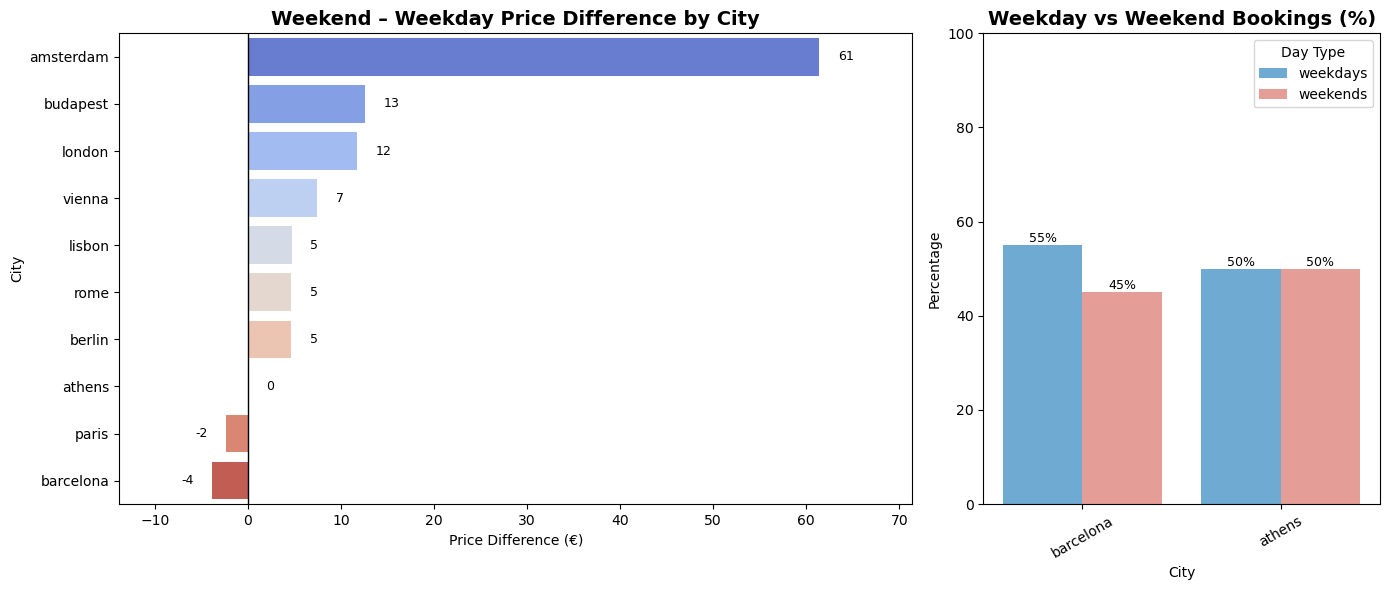

In [29]:
# --- LEFT PLOT: Price Difference ---
price_diff = df_airbnb.groupby(["city", "weekday/weekend"])["price"].median().unstack()
price_diff["difference"] = price_diff["weekends"] - price_diff["weekdays"]
price_diff = price_diff.sort_values("difference", ascending=False)

# --- RIGHT PLOT: Weekday vs Weekend Percentage (only selected cities) ---
booking_counts = df_airbnb.groupby(["city", "weekday/weekend"]).size().unstack(fill_value=0)
booking_perc = booking_counts.div(booking_counts.sum(axis=1), axis=0) * 100

# ✅ Keep only Barcelona and Athens
selected_cities = ["barcelona", "athens"]
booking_perc_selected = booking_perc.loc[selected_cities].reset_index().melt(
    id_vars="city", var_name="day_type", value_name="percentage"
)
booking_perc_selected["percentage"] = booking_perc_selected["percentage"].round(0)  # round to whole numbers

# --- Create subplots ---
fig, axes = plt.subplots(1, 2, figsize=(14, 6), gridspec_kw={'width_ratios': [2, 1]})

# ======================
# Left plot: Price difference
# ======================
sns.barplot(
    x=price_diff["difference"],
    y=price_diff.index,
    palette="coolwarm",
    orient="h",
    ax=axes[0]
)
axes[0].axvline(0, color="black", lw=1)

for i, (val, city) in enumerate(zip(price_diff["difference"], price_diff.index)):
    offset = 2
    if val >= 0:
        axes[0].text(val + offset, i, f"{val:.0f}", ha="left", va="center", fontsize=9)
    else:
        axes[0].text(val - offset, i, f"{val:.0f}", ha="right", va="center", fontsize=9)

x_min = price_diff["difference"].min() - 10
x_max = price_diff["difference"].max() + 10
axes[0].set_xlim(x_min, x_max)

axes[0].set_title("Weekend – Weekday Price Difference by City", fontsize=14, weight="bold")
axes[0].set_xlabel("Price Difference (€)")
axes[0].set_ylabel("City")

# ======================
# Right plot: Percentage comparison
# ======================
sns.barplot(
    data=booking_perc_selected,
    x="city",
    y="percentage",
    hue="day_type",
    palette=["#5DADE2", "#F1948A"],
    ax=axes[1]
)

# Add rounded value labels (no decimals)
for container in axes[1].containers:
    axes[1].bar_label(container, fmt="%.0f%%", fontsize=9)

axes[1].set_title("Weekday vs Weekend Bookings (%)", fontsize=14, weight="bold")
axes[1].set_ylabel("Percentage")
axes[1].set_xlabel("City")
axes[1].legend(title="Day Type")
axes[1].set_ylim(0, 100)
axes[1].tick_params(axis='x', rotation=30)

# ======================
plt.tight_layout()
plt.show()


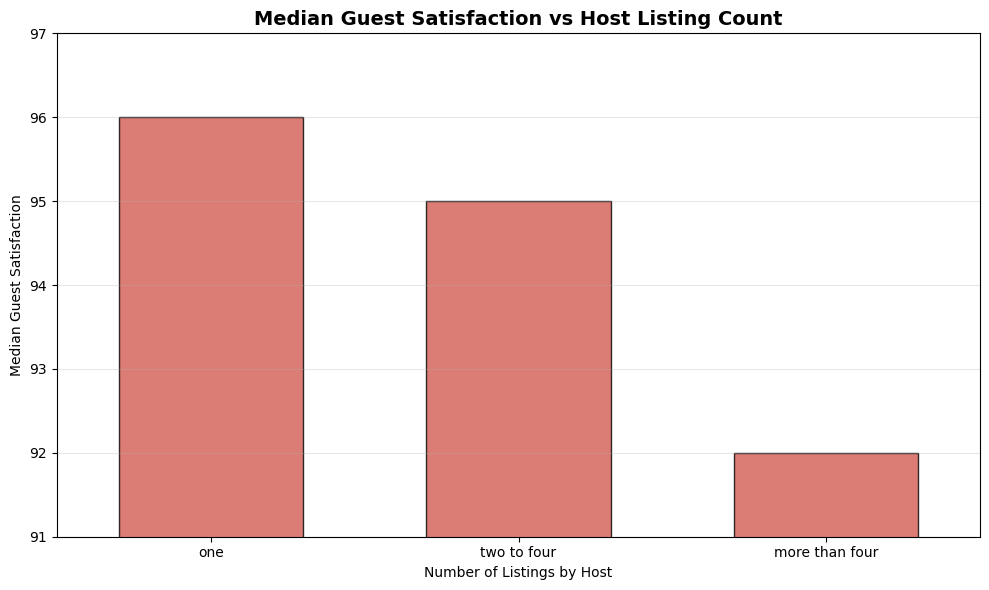

In [30]:
# Step 1️⃣: Compute median satisfaction per host listing count
median_satisfaction = (
    df_airbnb.groupby("host_listing_count", as_index=False)["guest_satisfaction_overall"]
    .median()
    .sort_values("guest_satisfaction_overall", ascending=False)
)

# Step 2️⃣: Plot as Bar Chart
plt.figure(figsize=(10,6))
sns.barplot(
    data=median_satisfaction,
    x="host_listing_count",
    y="guest_satisfaction_overall",
    color="#E74C3C",
    alpha=0.8,
    width=0.6,            # narrower bars → better spacing
    edgecolor="black"      # outlines help distinguish bars
)

# 🔹 Zoom in vertically to make small differences clearer
plt.ylim(
    median_satisfaction["guest_satisfaction_overall"].min() - 1,
    median_satisfaction["guest_satisfaction_overall"].max() + 1
)

plt.title("Median Guest Satisfaction vs Host Listing Count", fontsize=14, weight="bold")
plt.xlabel("Number of Listings by Host")
plt.ylabel("Median Guest Satisfaction")
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()


/var/folders/lc/rwbnk4114w78tcfk73z_364m0000gn/T/ipykernel_1353/1149402226.py:56: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title="")


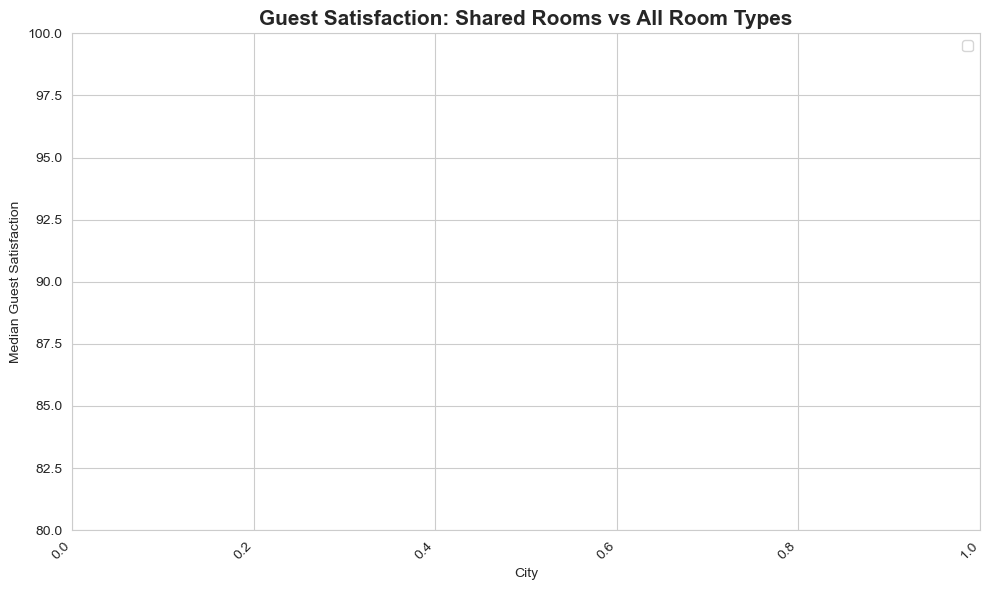

In [31]:

# 1️⃣ Compute city-wise overall median (all room types)
city_medians = (
    df_airbnb.groupby("city")["guest_satisfaction_overall"]
    .median()
    .rename("city_median")
)

# 2️⃣ Compute city-wise median for shared rooms
shared_medians = (
    df_airbnb[df_airbnb["room_type"] == "Shared room"]
    .groupby("city")["guest_satisfaction_overall"]
    .median()
    .rename("shared_median")
)

# 3️⃣ Combine into one dataframe
comparison = pd.concat([city_medians, shared_medians], axis=1).dropna()
comparison["difference"] = comparison["city_median"] - comparison["shared_median"]

# Sort cities by difference (largest gap first)
comparison = comparison.sort_values("difference", ascending=False).reset_index()

# 4️⃣ Melt for double bar plotting
melted = comparison.melt(
    id_vars="city",
    value_vars=["city_median", "shared_median"],
    var_name="Type",
    value_name="Median_Satisfaction"
)

# Rename types for prettier legend
melted["Type"] = melted["Type"].map({
    "city_median": "All Room Types",
    "shared_median": "Shared Rooms"
})

# 5️⃣ Plot double bar chart
plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")

sns.barplot(
    data=melted,
    x="city",
    y="Median_Satisfaction",
    hue="Type",
    palette=["#2C3E50", "#E74C3C"],
    edgecolor="black"
)

# Labels and styling
plt.title("Guest Satisfaction: Shared Rooms vs All Room Types", fontsize=15, weight="bold")
plt.ylabel("Median Guest Satisfaction")
plt.xlabel("City")
plt.xticks(rotation=45, ha="right")
plt.ylim(80, 100)
plt.legend(title="")
plt.tight_layout()
plt.show()


In [3]:
#checking for missing values
df_airbnb.isna().sum()

Unnamed: 0                    0
realSum                       0
room_type                     0
room_shared                   0
room_private                  0
person_capacity               0
host_is_superhost             0
multi                         0
biz                           0
cleanliness_rating            0
guest_satisfaction_overall    0
bedrooms                      0
dist                          0
metro_dist                    0
attr_index                    0
attr_index_norm               0
rest_index                    0
rest_index_norm               0
lng                           0
lat                           0
sheet                         0
dtype: int64

In [4]:
#checking duplicates in the dataframe
df_airbnb.duplicated().sum()
print(f"This dataset has {int(df_airbnb.duplicated().sum())} duplicates")

This dataset has 0 duplicates


In [35]:
# ANOVA test: satisfaction across cities differs significantly
groups = [df_airbnb[df_airbnb["city"]==c]["guest_satisfaction_overall"] for c in df_airbnb["city"].unique()]
f_stat, p_value = stats.f_oneway(*groups)
print(f_stat, p_value)

183.31083353929782 0.0


In [32]:
# T-test: guest satisfaction if business/not business differs significantly
t_stat, p_value = stats.ttest_ind(df[df.biz==0]["guest_satisfaction_overall"],
                df[df.biz==1]["guest_satisfaction_overall"])
print("t =", t_stat)
print("p =", p_value)

t = 10.470307333829997
p = 6.074638008877086e-25


In [33]:
mean_non_biz = df[df.biz==0]["guest_satisfaction_overall"].mean()
mean_biz = df[df.biz==1]["guest_satisfaction_overall"].mean()
print("Mean non-business:", mean_non_biz)
print("Mean business:", mean_biz)

Mean non-business: 94.94152542372882
Mean business: 91.23747980613894


In [40]:
# Checking dependence of user satisfaction on other values
categorical_vars = ['host_listing_count', 'host_is_superhost', 'weekday/weekend', 'room_type']

for var in categorical_vars:
    table = pd.crosstab(df_airbnb[var], df_airbnb['guest_satisfaction_overall'])
    chi2, p, dof, expected = stats.chi2_contingency(table)
    print(f"Chi-square test for {var} vs guest_satisfaction:")
    print(f"Chi2 = {chi2:.2f}, p = {p:.5f}\n")

Chi-square test for host_listing_count vs guest_satisfaction:
Chi2 = 3950.92, p = 0.00000

Chi-square test for host_is_superhost vs guest_satisfaction:
Chi2 = 14117.53, p = 0.00000

Chi-square test for weekday/weekend vs guest_satisfaction:
Chi2 = 21.48, p = 0.99994

Chi-square test for room_type vs guest_satisfaction:
Chi2 = 406.00, p = 0.00000



/var/folders/lc/rwbnk4114w78tcfk73z_364m0000gn/T/ipykernel_1353/3432735908.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


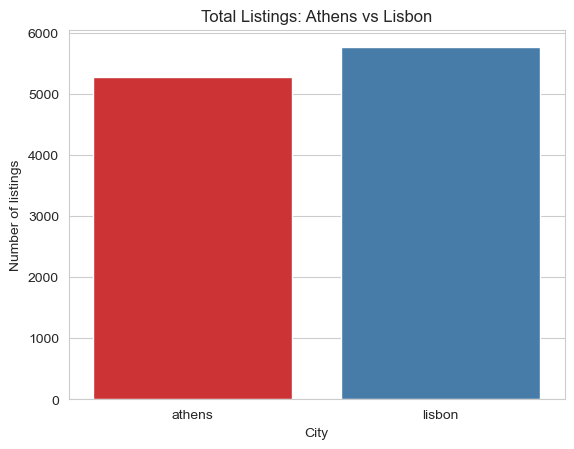

In [41]:
# Comparing cities with the highest and lowest guest satisfaction

counts = (
    df_airbnb[df_airbnb['city'].isin(['athens', 'lisbon'])]
    .groupby('city')
    .size()
    .reset_index(name='total_listings')
)

sns.barplot(
    x='city',
    y='total_listings',
    data=counts,
    palette='Set1'
)

plt.title("Total Listings: Athens vs Lisbon")
plt.ylabel("Number of listings")
plt.xlabel("City")
plt.show()

/var/folders/lc/rwbnk4114w78tcfk73z_364m0000gn/T/ipykernel_1353/2051979238.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='city', y='guest_satisfaction_overall', data=df_guest_filtered, palette="Set1")


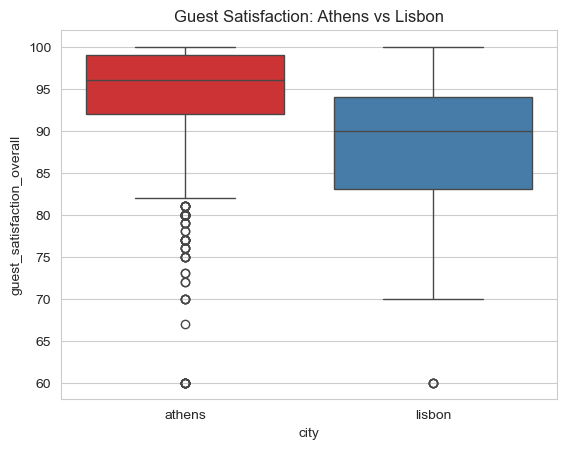

In [42]:
# Guest satisfaction

cities = ['athens', 'lisbon']
df_sel = df_airbnb[df_airbnb['city'].isin(cities)]

# Keep data between 1st and 99th percentile
lower = df_sel['guest_satisfaction_overall'].quantile(0.01)
upper = df_sel['guest_satisfaction_overall'].quantile(0.99)
df_guest_filtered = df_sel[(df_sel['guest_satisfaction_overall'] >= lower) & (df_sel['price'] <= upper)]

sns.boxplot(x='city', y='guest_satisfaction_overall', data=df_guest_filtered, palette="Set1")
plt.title("Guest Satisfaction: Athens vs Lisbon")
plt.show()

/var/folders/lc/rwbnk4114w78tcfk73z_364m0000gn/T/ipykernel_1353/3385565001.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='city', y='price', data=df_filtered, palette="Set1")


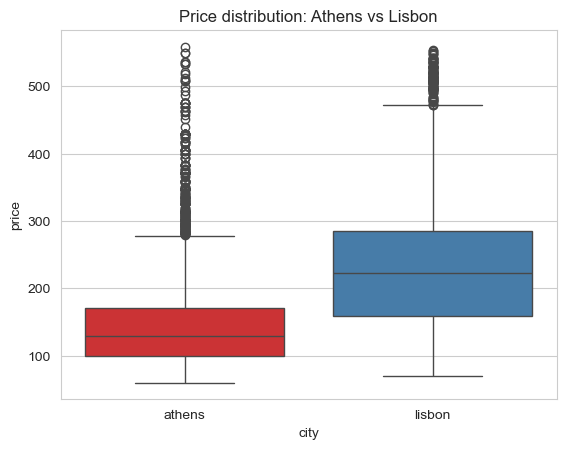

In [43]:
# Boxplot for price

# Keep data between 1st and 99th percentile
lower = df_sel['price'].quantile(0.01)
upper = df_sel['price'].quantile(0.99)
df_filtered = df_sel[(df_sel['price'] >= lower) & (df_sel['price'] <= upper)]

sns.boxplot(x='city', y='price', data=df_filtered, palette="Set1")
plt.title("Price distribution: Athens vs Lisbon")
plt.show()

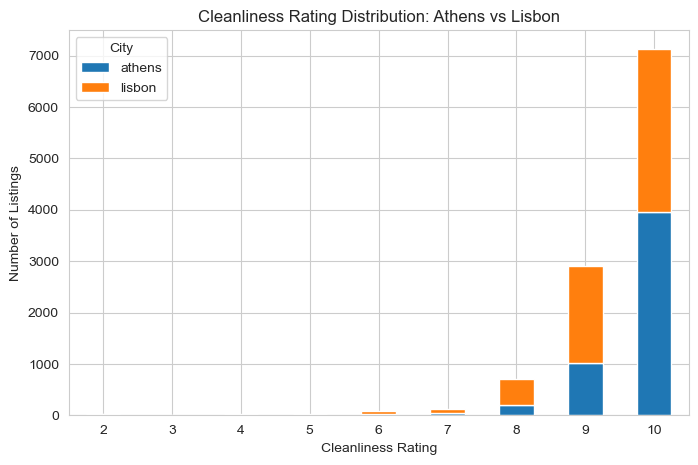

In [44]:
# Barplot for cleanliness ratings

counts = df_sel.groupby(['cleanliness_rating', 'city']).size().unstack(fill_value=0)

counts.plot(kind='bar', stacked=True, figsize=(8,5))
plt.xlabel("Cleanliness Rating")
plt.ylabel("Number of Listings")
plt.title("Cleanliness Rating Distribution: Athens vs Lisbon")
plt.xticks(rotation=0)
plt.legend(title="City")
plt.show()

/var/folders/lc/rwbnk4114w78tcfk73z_364m0000gn/T/ipykernel_1353/3030568245.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='city', y='dist', data=df_sel, palette="Set1")


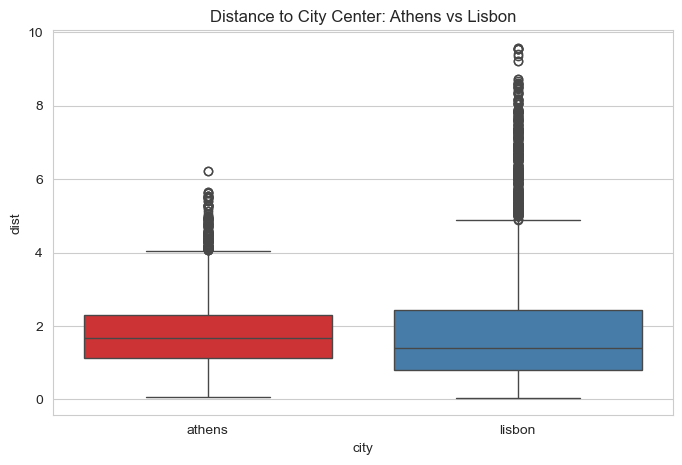

dist t-test: t = -6.05, p = 0.00000



In [45]:
# Distance to city center
plt.figure(figsize=(8,5))
sns.boxplot(x='city', y='dist', data=df_sel, palette="Set1")
plt.title("Distance to City Center: Athens vs Lisbon")
plt.show()

t_stat, p_value = stats.ttest_ind(
    df_sel[df_sel.city=='athens']['dist'],
    df_sel[df_sel.city=='lisbon']['dist']
)
print(f"dist t-test: t = {t_stat:.2f}, p = {p_value:.5f}\n")

/var/folders/lc/rwbnk4114w78tcfk73z_364m0000gn/T/ipykernel_1353/4216756835.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='city', y='metro_dist', data=df_filtered, palette='Set1')


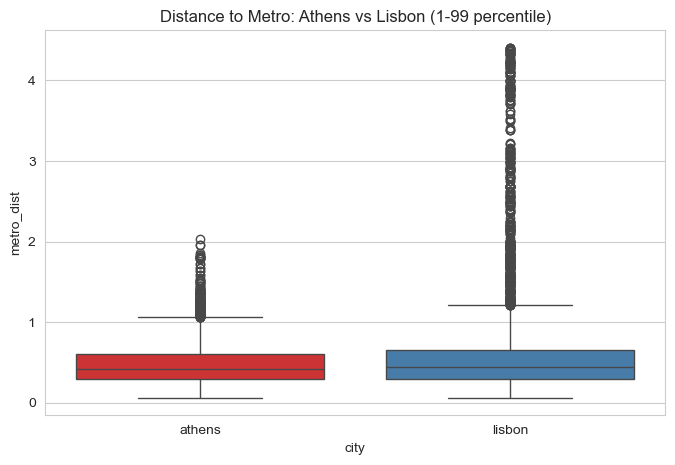

metro_dist t-test: t = -14.66, p = 0.00000



In [46]:
# Distance to metro

lower = df_sel['metro_dist'].quantile(0.01)
upper = df_sel['metro_dist'].quantile(0.99)
df_filtered = df_sel[(df_sel['metro_dist'] >= lower) & (df_sel['metro_dist'] <= upper)]

plt.figure(figsize=(8,5))
sns.boxplot(x='city', y='metro_dist', data=df_filtered, palette='Set1')
plt.title("Distance to Metro: Athens vs Lisbon (1-99 percentile)")
plt.show()

t_stat, p_value = stats.ttest_ind(
    df_filtered[df_filtered.city=='athens']['metro_dist'],
    df_filtered[df_filtered.city=='lisbon']['metro_dist']
)
print(f"metro_dist t-test: t = {t_stat:.2f}, p = {p_value:.5f}\n")

/var/folders/lc/rwbnk4114w78tcfk73z_364m0000gn/T/ipykernel_1353/3127584451.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='city', y='attr_index', data=df_filtered, palette='Set1')


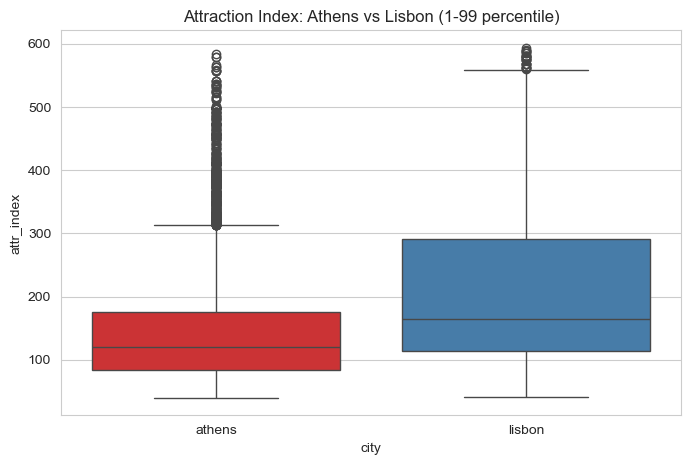

attr_index t-test: t = -28.68, p = 0.00000



In [47]:
# Attraction index (filtered in 1-99 percentile due to extreme outliers)
lower = df_sel['attr_index'].quantile(0.01)
upper = df_sel['attr_index'].quantile(0.99)
df_filtered = df_sel[(df_sel['attr_index'] >= lower) & (df_sel['attr_index'] <= upper)]

plt.figure(figsize=(8,5))
sns.boxplot(x='city', y='attr_index', data=df_filtered, palette='Set1')
plt.title("Attraction Index: Athens vs Lisbon (1-99 percentile)")
plt.show()

t_stat, p_value = stats.ttest_ind(
    df_filtered[df_filtered.city=='athens']['attr_index'],
    df_filtered[df_filtered.city=='lisbon']['attr_index']
)
print(f"attr_index t-test: t = {t_stat:.2f}, p = {p_value:.5f}\n")

/var/folders/lc/rwbnk4114w78tcfk73z_364m0000gn/T/ipykernel_1353/979850087.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='city', y='rest_index', data=df_filtered, palette='Set1')


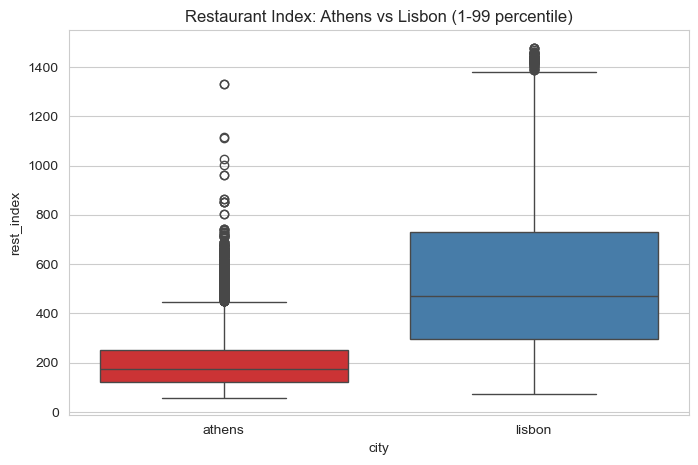

rest_index t-test: t = -65.36, p = 0.00000



In [48]:
# Restaurant index (filtered in 1-99 percentile due to extreme outliers)
lower = df_sel['rest_index'].quantile(0.01)
upper = df_sel['rest_index'].quantile(0.99)
df_filtered = df_sel[(df_sel['rest_index'] >= lower) & (df_sel['rest_index'] <= upper)]

plt.figure(figsize=(8,5))
sns.boxplot(x='city', y='rest_index', data=df_filtered, palette='Set1')
plt.title("Restaurant Index: Athens vs Lisbon (1-99 percentile)")
plt.show()

t_stat, p_value = stats.ttest_ind(
    df_filtered[df_filtered.city=='athens']['rest_index'],
    df_filtered[df_filtered.city=='lisbon']['rest_index']
)
print(f"rest_index t-test: t = {t_stat:.2f}, p = {p_value:.5f}\n")

/var/folders/lc/rwbnk4114w78tcfk73z_364m0000gn/T/ipykernel_1353/979850087.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='city', y='rest_index', data=df_filtered, palette='Set1')


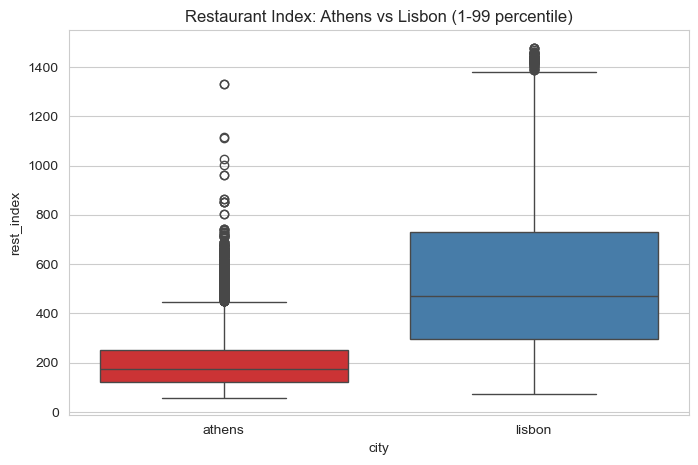

rest_index t-test: t = -65.36, p = 0.00000



In [49]:
# Restaurant index (filtered in 1-99 percentile due to extreme outliers)
lower = df_sel['rest_index'].quantile(0.01)
upper = df_sel['rest_index'].quantile(0.99)
df_filtered = df_sel[(df_sel['rest_index'] >= lower) & (df_sel['rest_index'] <= upper)]

plt.figure(figsize=(8,5))
sns.boxplot(x='city', y='rest_index', data=df_filtered, palette='Set1')
plt.title("Restaurant Index: Athens vs Lisbon (1-99 percentile)")
plt.show()

t_stat, p_value = stats.ttest_ind(
    df_filtered[df_filtered.city=='athens']['rest_index'],
    df_filtered[df_filtered.city=='lisbon']['rest_index']
)
print(f"rest_index t-test: t = {t_stat:.2f}, p = {p_value:.5f}\n")

Room type — Chi2 = 1046.01, p = 0.00000
----------------------------------------------------------------------


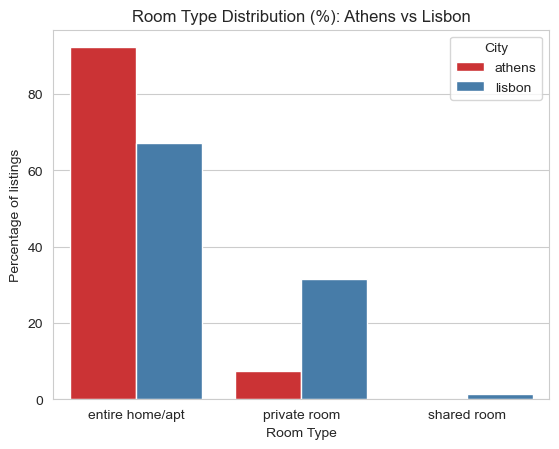

In [51]:
# Type of accomodation
room_counts = (
    df_sel[df_sel['city'].isin(['athens', 'lisbon'])]
    .groupby(['city', 'room_type'])
    .size()
    .reset_index(name='count')
)

room_counts['percent'] = room_counts.groupby('city')['count'].transform(lambda x: 100 * x / x.sum())

# Chi-square test
ct_room = pd.crosstab(
    df_sel[df_sel['city'].isin(['athens', 'lisbon'])]['city'], 
    df_sel[df_sel['city'].isin(['athens', 'lisbon'])]['room_type']
)
chi2, p, dof, expected = stats.chi2_contingency(ct_room)
print(f"Room type — Chi2 = {chi2:.2f}, p = {p:.5f}")
print("-" * 70)

# Barplot
sns.barplot(
    x='room_type',
    y='percent',
    hue='city',
    data=room_counts,
    palette='Set1'
)
plt.title('Room Type Distribution (%): Athens vs Lisbon')
plt.ylabel('Percentage of listings')
plt.xlabel('Room Type')
plt.legend(title='City')
plt.show()

Superhost Status — Chi2 = 585.79, p = 0.00000
----------------------------------------------------------------------


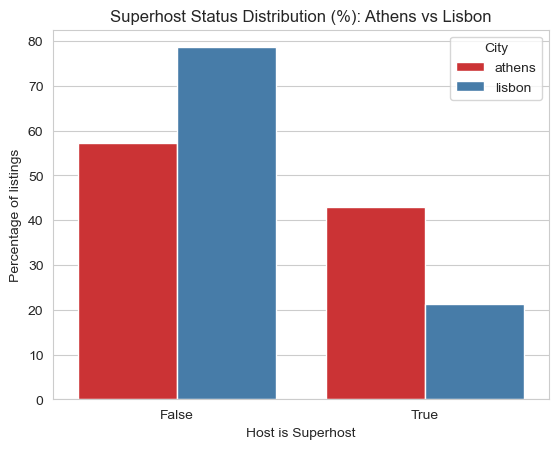

In [52]:
# Host is superhost?
superhost_counts = (
    df_sel[df_sel['city'].isin(['athens', 'lisbon'])]
    .groupby(['city', 'host_is_superhost'])
    .size()
    .reset_index(name='count')
)

superhost_counts['percent'] = superhost_counts.groupby('city')['count'].transform(lambda x: 100 * x / x.sum())

# Chi-square test
ct_superhost = pd.crosstab(
    df_sel[df_sel['city'].isin(['athens', 'lisbon'])]['city'], 
    df_sel[df_sel['city'].isin(['athens', 'lisbon'])]['host_is_superhost']
)
chi2, p, dof, expected = stats.chi2_contingency(ct_superhost)
print(f"Superhost Status — Chi2 = {chi2:.2f}, p = {p:.5f}")
print("-" * 70)

# Barplot
sns.barplot(
    x='host_is_superhost',
    y='percent',
    hue='city',
    data=superhost_counts,
    palette='Set1'
)
plt.title('Superhost Status Distribution (%): Athens vs Lisbon')
plt.ylabel('Percentage of listings')
plt.xlabel('Host is Superhost')
plt.legend(title='City')
plt.show()

Host Listing Category — Chi2 = 595.28, p = 0.00000
----------------------------------------------------------------------


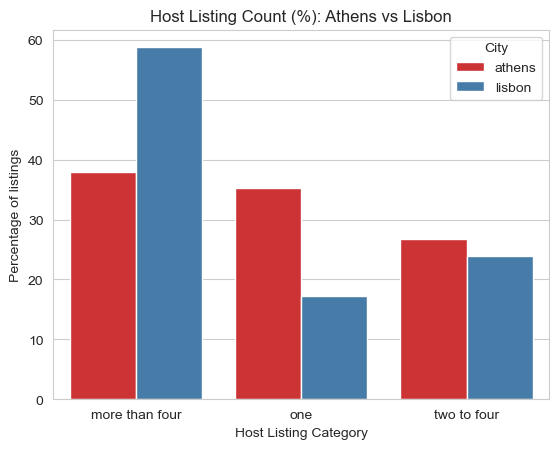

In [53]:
# Host Listing Count
host_counts = (
    df_sel[df_sel['city'].isin(['athens', 'lisbon'])]
    .groupby(['city', 'host_listing_count']) 
    .size()
    .reset_index(name='count')
)

host_counts['percent'] = host_counts.groupby('city')['count'].transform(lambda x: 100 * x / x.sum())

# Chi-square test
ct_host = pd.crosstab(
    df_sel[df_sel['city'].isin(['athens', 'lisbon'])]['city'], 
    df_sel[df_sel['city'].isin(['athens', 'lisbon'])]['host_listing_count']
)
chi2, p, dof, expected = stats.chi2_contingency(ct_host)
print(f"Host Listing Category — Chi2 = {chi2:.2f}, p = {p:.5f}")
print("-" * 70)

# Barplot
sns.barplot(
    x='host_listing_count',
    y='percent',
    hue='city',
    data=host_counts,
    palette='Set1'
)
plt.title('Host Listing Count (%): Athens vs Lisbon')
plt.ylabel('Percentage of listings')
plt.xlabel('Host Listing Category')
plt.legend(title='City')
plt.show()